# What is WSJF (Weighted Shortest Job First) rule in SAFE (Scaled Agile Framework)?

You are a product manager in an Agile company. 
You and your team deliver several 'features' each sprint (period of 2 weeks after which you effectively deliver new features customers can use 'in production' thanks to 'continuous delivery'). 
But each sprint you have the same challenges: you need to satisfy your clients by 'delivering' what is most important AND you need to make sure your team can handle the workload over 2 weeks in a sustainable and healthy way.
Should you prioritise the most critical feature? then what if it is too complex and you end up doing nothing else in the 2 weeks sprint? OR should you prioritise the quickest/easiest features so as to deliver 'a lot'? then what is these features are too low value and do not really benefit customers...
Here comes of a specific part of SAFE (Scaled Agile framework, more information here: https://www.scaledagileframework.com/) providing best practices for prioritisation, using 'poker planning' and WSJF (Weighted Shortest Job First, more information here: https://www.scaledagileframework.com/wsjf/).

# Formulating the prioritisation question as a 'knapsack problem'

This nice coursera video illustrates the well-known knapsack problem: https://www.coursera.org/lecture/discrete-optimization/knapsack-1-intuition-n2TGL. Basically we are trying to fit features (<=> items to pack in the bag) within a limited team workload capacity (<=> size of the bag), each feature having a complexity/job length (<=> items volume) and a business value (<=> items price). Our objective is to deliver maximum value to customers (<=> fill the bag with items so that the total item price is maximum inside the bag).

# Is WSJF optimal? actually... it can be improved by 1-2% on average and sometimes up to 30%! (in terms business value per sprint)

**Basically WSJF** consists in calculating for each feature the ratio VALUE / COMPLEXITY or to be more accurate: COST OF DELAY / JOB DURATION, then higher this ratio => higher the pirority. It **is a form of Greedy Approach** in optimisation algorithms (density based, since we calculate ~ value/cost). The following sections will **consider another algorithm** regarded as more advanced than greedy approaches, with **objective** to assess WSJF performance (in terms of average value / sprint delivered to customers) and **evaluate the benefits of using something different than WSJF**.

# It all comes to 'Greedy Vs Branch&Bound' algorithm comparison

As we said WSJF is a 'Greedy' algorithm, let's compare it with Branch & Bound for example (great videa here: https://www.coursera.org/learn/discrete-optimization/lecture/66OlO/knapsack-5-relaxation-branch-and-bound). Branch&Bound consists in iteratively exploring a search tree (branching step) while reducing the search space as much as possible by removing sub-parts of the tree (bounding step) in order to reduce complexity of this NP-Complete problem. In the next sections we define the greedy & Branch&Bound functions, simulate the inputs to get as close as possible to what may happen in product management with multiple/heterogeneous features requested each sprint, and run a performance comparison montecarlo-like. So it all comes now to comparing Greedy Vs Branch&bound!

## Generating the inputs using Fibonacci scores for 'value' & 'complexity'

A good practice in Product Management is to score value & complexity on a specific scale called 'Fibonacci', so that our brain does not struggle with estimations (often a difficult exercice). Indeed I bet you would be challenged to choose between 20 and 21 to assess a complexity score given these numbers are so close... and it becomes harder as the numbers are bigger, e.g. can you choose between 38 and 39? This is why the recommendation is to use specific scale with a growing difference between numbers as the numners are big, just like Fibonacci: 1,2,3,5,8,13... (U(n)=U(n-1)+U(n-2)).

In [40]:
## Product Owners often use this fibonacci scale to estimate value (more accurately Cost of Delay) Vs complexity (more accurately Job Length)
fibonacci = [1,2,3,5,8,13,21,34,55,89]
## We will later sample our complexities and values from this list of numbers
import random 

In [41]:
## The paradigm in Agility is that TIME is fixed, CAPACITY is fixed, and only SCOPE can vary (features to develop)
## (example: 10 complementary coders in a team)
## For the sake of example, let's fix CAPACITY = 100. Our team can deliver 100 points worth of complexity / sprint.
capacities = [100]

## Greedy algorithm: 'density' based just like WSJF

In [42]:
# Inputs for testing
#values = [1,2,3,4]
#weights = [[4,3,2,1]]
#capacities = [4]

# Greedy algorithm based on densities
def greedy_density(values, weights, capacities):
    densities = [[values[i]/float(weights[0][i]), weights[0][i]] for i in range(0,len(values))]
    densities = sorted(densities, reverse=True)
    total_value_greedy = 0
    total_weight_greedy = 0
    for i in range(0,len(values)):
        ##print(i)
        if total_weight_greedy + densities[i][1] <= capacities[0]: ## only if there is still capacity to add the next item
            total_weight_greedy += densities[i][1] ## we add the weight of the selected object
            total_value_greedy += densities[i][1]*densities[i][0] ## we multiply to get the value = numerator

    ##print("Total value with Greedy (density based): ", total_value_greedy)
    #print("Total weight with Greedy (density based): ", total_weight_greedy)
    return([total_value_greedy,total_weight_greedy])

##greedy_density(values, weights, capacities) ## testing the function

## More advanced algorithm: let's use Branch & Bound as a reference

In [43]:
# Branch & Bound algorithm
from ortools.algorithms import pywrapknapsack_solver

def Banch_and_bound(values, weights, capacities):
  # Create the solver.
    solver = pywrapknapsack_solver.KnapsackSolver(
          pywrapknapsack_solver.KnapsackSolver.
          KNAPSACK_MULTIDIMENSION_BRANCH_AND_BOUND_SOLVER,
          'test')

    solver.Init(values, weights, capacities)
    computed_value = solver.Solve()

    packed_items = [x for x in range(0, len(weights[0]))
                      if solver.BestSolutionContains(x)]
    packed_weights = [weights[0][i] for i in packed_items]
    total_weight= sum(packed_weights)
    
    ##print("Packed items: ", packed_items)
    ##print("Packed weights: ", packed_weights)
    
    ##print("Total value with Branch&Bound: ", computed_value)
    ##print("Total weight with Branch&Bound: ", total_weight)
    
    return([computed_value,total_weight])
    ##if __name__ == '__main__':
      ##main()

## Banch_and_bound(values, weights, capacities) ## testing the function

## Montecarlo Simulation: running 1000 different scenarios

In [50]:
import pandas as pd
Performance_comparison = pd.DataFrame(columns=['Greedy_value','BranchBound_value'])

for i in range(1000):
    ## Montecarlo loop starts here ####################################################
    ## Run random sampling to create inputs
    values = random.choices(population=fibonacci, k=10) ##[1,2,3,4]
    weights = [random.choices(population=fibonacci, k=10)]## [[4,3,2,1]]

    ## Run optimisation algorithms
    greedy = greedy_density(values, weights, capacities)[0]
    branchbound = Banch_and_bound(values, weights, capacities)[0]

    ## Add results for comparison
    Performance_comparison = Performance_comparison.append({'Greedy_value':greedy, 'BranchBound_value':branchbound},ignore_index=True)
    ## Montecarlo loop ends here ####################################################

## View results 
Performance_comparison.head(20) ## only the first 20 rows

,Greedy_value,BranchBound_value
0,173.0,173.0
1,69.0,70.0
2,275.0,280.0
3,161.0,161.0
4,225.0,225.0
5,157.0,157.0
6,228.0,228.0
7,84.0,90.0
8,223.0,223.0
9,477.0,477.0


## Results confirm Branch&Bond performs better by 1-2% on average...

C:\Users\Samir A Ghoudrani\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


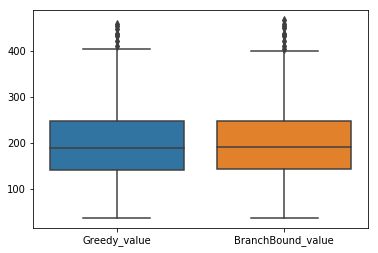

In [45]:
## Plot distributions
import sys
import seaborn as sns
# Make boxplot for one group only
sns.boxplot(data=Performance_comparison.ix[:,0:2])

In [46]:
import numpy as np
np.mean(Performance_comparison['Greedy_value'])

197.169

In [47]:
np.mean(Performance_comparison['BranchBound_value'])

199.824

In [48]:
print("Avg Percentage of value difference")
print(round(100*(np.mean(Performance_comparison['BranchBound_value'])-np.mean(Performance_comparison['Greedy_value']))/np.mean(Performance_comparison['Greedy_value']),1),"% more value compared to WSJF, if we use a more advanced optimisation algorithm like Branch&Bound")

Avg Percentage of value difference
1.3 % more value compared to WSJF, if we use a more advanced optimisation algorithm like Branch&Bound


## ...and even sometimes up to 30% better!

C:\Users\Samir A Ghoudrani\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


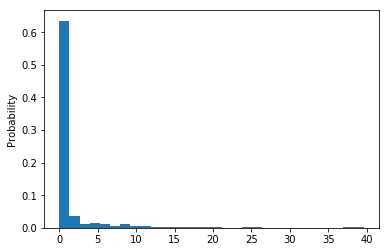

In [49]:
Performance_comparison['Delta'] = round(100*((Performance_comparison['BranchBound_value'])-(Performance_comparison['Greedy_value']))/np.mean(Performance_comparison['Greedy_value']),1)

import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(Performance_comparison['Delta'], normed=True, bins=30)
plt.ylabel('Probability');